# Text-To-Text LLM Server

**important: Select venv Python Interpreter before you start**

This repository is designed to be used with Visual Studio Code and Docker DevContainer.

![dev-container](../img/dev-container.png)

## 1. Setup

**Instructions:**

a) Download model

```bash
huggingface-cli download bartowski/Mistral-7B-Instruct-v0.3-exl2 \
    --revision 1a09a351a5fb5a356102bfca2d26507cdab11111 \
    --local-dir ~/.gai/models/exllamav2-mistral7b \
    --local-dir-use-symlinks False
```

or

```bash
huggingface-cli download bartowski/dolphin-2.9-llama3-8b-exl2 \
    --revision 6521bd8b0f793a038f85d445316c94cdd0957d8e \
    --branch 4_25 \
    --local-dir ~/.gai/models/exllamav2-mistral7b \
    --local-dir-use-symlinks False
```


---

## 2. Smoke Test

In [1]:
# check .gairc
import os
gairc=None
with open(os.path.expanduser("~/.gairc"),"r") as f:
    gairc = f.read()
print(gairc)

# check ~/.gairc (if docker created .gairc)
import json
jsoned=json.loads(gairc)
assert jsoned["app_dir"]=="/home/kakkoii1337/.gai"

# check ~/.gai (if docker created the mount point)
assert os.path.exists(os.path.expanduser("~/.gai"))

# Initiate
from gai.lib.server.singleton_host import SingletonHost
from gai.lib.common.utils import free_mem
from rich.console import Console
console=Console()

config = {
    "type": "ttt",
    "generator_name": "exllamav2-mistral7b",
    "engine": "gai.ttt.server.GaiExLlamaV2",
    "model_path": "models/exllamav2-mistral7b",
    "model_basename": "model",
    "max_seq_len": 8192,
    "prompt_format": "mistral",
    "hyperparameters": {
        "temperature": 0.85,
        "top_p": 0.8,
        "top_k": 50,
        "max_new_tokens": 1000,
    },
    "tool_choice": "auto",
    "max_retries": 5,
    "stop_conditions": ["<s>", "</s>", "user:","\n\n"],
    "no_flash_attn":True,
    "seed": None,
    "decode_special_tokens": False,
    "module_name": "gai.ttt.server.gai_exllamav2",
    "class_name": "GaiExLlamav2",
    "init_args": [],
    "init_kwargs": {}
}

# before loading
free_mem()
try:
    with SingletonHost.GetInstanceFromConfig(config) as host:

        # after loading
        free_mem()
except Exception as e:
    raise e
finally:
    # after disposal
    free_mem()

{"app_dir":"/home/kakkoii1337/.gai"}



Free memory: 5.56 GB

                      Performance load_config                      
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Metric            ┃ Initial Value ┃ Change Value ┃  Final Value ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ Function Duration │             - │ 4.80 seconds │ 4.80 seconds │
│ CPU Memory        │          - MB │     21.32 MB │     21.32 MB │
│ CUDA Memory       │       5.57 GB │     -0.02 GB │      5.59 GB │
└───────────────────┴───────────────┴──────────────┴──────────────┘

                      Performance load_model                       
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Metric            ┃ Initial Value ┃ Change Value ┃  Final Value ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ Function Duration │             - │ 0.01 seconds │ 0.01 seconds │
│ CPU Memory        │          - MB │      0.22 MB │      0.22 MB │
│ CUDA Memory       │       5.59 GB │      0.00 GB │      5.59 GB │
└───────────────────┴───────────────┴──────────────┴──────────────┘

                       Performance load_cache                        
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Metric            ┃ Initial Value ┃  Change Value ┃   Final Value ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Function Duration │             - │ 27.79 seconds │ 27.79 seconds │
│ CPU Memory        │          - MB │      24.17 MB │      24.17 MB │
│ CUDA Memory       │       5.59 GB │       4.64 GB │       0.95 GB │
└───────────────────┴───────────────┴───────────────┴───────────────┘

                    Performance load_tokenizer                     
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Metric            ┃ Initial Value ┃ Change Value ┃  Final Value ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ Function Duration │             - │ 2.93 seconds │ 2.93 seconds │
│ CPU Memory        │          - MB │     49.61 MB │     49.61 MB │
│ CUDA Memory       │       0.95 GB │     -0.01 GB │      0.95 GB │
└───────────────────┴───────────────┴──────────────┴──────────────┘

Free memory: 0.95 GB

Free memory: 5.46 GB

---

## 3. Integration Test

### Startup

In [2]:
host = SingletonHost.GetInstanceFromConfig(config, verbose=False)
host.load()
generator = host.generator
free_mem()

Free memory: 0.94 GB

0.9435691833496094

### a) Test streaming

In [3]:
response = host.generator.create(
    messages=[{"role":"user","content":"Tell me a one paragraph story"},
                {"role":"assistant","content":""}],
    stream=True)
for message in response:
    if message.choices[0].delta.content:
        print(message.choices[0].delta.content, end="", flush=True)
   

 Once upon a time, in a small village nestled between the mountains, lived a kind-hearted girl named Mia. She was known for her radiant smile and her selfless acts of kindness. One day, during a harsh winter storm, Mia found a lost traveler near the edge of a cliff. With no other choice, she risked her own life to bring the stranger back to the village. Her courage and compassion saved the traveler's life, earning her the respect and admiration of everyone in the village.


### b) Test generation

In [4]:

response = host.generator.create(
    messages=[{"role":"user","content":"Tell me a one paragraph story"},
                {"role":"assistant","content":""}],
    stream=False)
print(response.choices[0].message.content)


 Once upon a time, in a small village nestled between the mountains, lived a kind-hearted young woman named Maya. She was known for her radiant smile and her selfless act of helping others. One day, she found a wounded bird in her garden. Instead of leaving it alone, she took care of it, nursing it back to health. Her kindness and compassion earned her the love and respect of the entire village. Maya's story serves as an inspiration to all, reminding us that even the smallest acts of kindness can make a significant difference in someone's life.


### c) Test Tool Calling

In [5]:
messages = [
    {"role":"user","content":"What is the current time in Singapore?"},
    {"role":"assistant","content":""}
]
tool_choice="required"
tools = [
    {
        "type": "function",
        "function": {
            "name": "google",
            "description": "The 'google' function is a powerful tool that allows the AI to gather external information from the internet using Google search. It can be invoked when the AI needs to answer a question or provide information that requires up-to-date, comprehensive, and diverse sources which are not inherently known by the AI. For instance, it can be used to find current date, current news, weather updates, latest sports scores, trending topics, specific facts, or even the current date and time. The usage of this tool should be considered when the user's query implies or explicitly requests recent or wide-ranging data, or when the AI's inherent knowledge base may not have the required or most current information. The 'search_query' parameter should be a concise and accurate representation of the information needed.",
            "parameters": {
                "type": "object",
                "properties": {
                    "search_query": {
                        "type": "string",
                        "description": "The search query to search google with. For example, to find the current date or time, use 'current date' or 'current time' respectively."
                    }
                },
                "required": ["search_query"]
            }
        }
    }
]
response = host.generator.create(
    messages=messages,
    tools=tools,
    tool_choice=tool_choice,
    stream=False)
print(response)


ChatCompletion(id='chatcmpl-f7d67f01-f2d6-43a5-9074-43b03438bcf5', choices=[Choice(finish_reason='tool_calls', index=0, logprobs=None, message=ChatCompletionMessage(content=None, refusal=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_b182432a-5ff8-416d-ad73-45726e2a8483', function=Function(arguments='{"search_query": "current time Singapore"}', name='google'), type='function')]))], created=1725094145, model='exllamav2-mistral7b', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=21, prompt_tokens=336, total_tokens=357))


### d) Test Structured Output

In [6]:
# Define Schema
from pydantic import BaseModel
class Book(BaseModel):
    title: str
    summary: str
    author: str
    published_year: int

text = """Foundation is a science fiction novel by American writer
Isaac Asimov. It is the first published in his Foundation Trilogy (later
expanded into the Foundation series). Foundation is a cycle of five
interrelated short stories, first published as a single book by Gnome Press
in 1951. Collectively they tell the early story of the Foundation,
an institute founded by psychohistorian Hari Seldon to preserve the best
of galactic civilization after the collapse of the Galactic Empire.
"""
response = host.generator.create(messages=[{'role':'user','content':text},{'role':'assistant','content':''}], 
    json_schema=Book.schema(),
    stream=False
    )
print(response)


ChatCompletion(id='chatcmpl-cb8d10ab-87f7-409f-8b54-bfa73b049664', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content=' {\n  "title": "Foundation",\n  "summary": "Foundation is a science fiction novel by Isaac Asimov, the first published in his Foundation Trilogy. It is a cycle of five interrelated short stories that tell the early story of the Foundation, an institute founded by psychohistorian Hari Seldon to preserve the best of galactic civilization after the collapse of the Galactic Empire.",\n  "author": "Isaac Asimov",\n  "published_year": 1951\n}', refusal=None, role='assistant', function_call=None, tool_calls=None))], created=1725094154, model='exllamav2-mistral7b', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=116, prompt_tokens=257, total_tokens=373))


### Teardown

In [7]:
del host.generator.model
del host.generator.cache
del host.generator.tokenizer
del host.generator
import gc,torch
gc.collect()
torch.cuda.empty_cache()
free_mem()

Free memory: 3.37 GB

3.366230010986328

---

## 4. API Test

**Instructions**:

a) Press `F5` to start the API server.

b) Wait for the server to start.

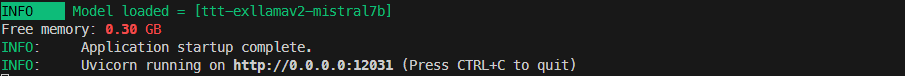

**Tests**:

Run the following cells to test the API.

### a) Test Generating

In [1]:
%%bash
curl -X POST \
    http://localhost:12031/gen/v1/chat/completions \
    -H 'Content-Type: application/json' \
    -s \
    -N \
    -d "{\"model\":\"exllamav2-mistral7b\", \
        \"messages\": [ \
            {\"role\": \"user\",\"content\": \"Tell me a story.\"}, \
            {\"role\": \"assistant\",\"content\": \"\"} \
        ],\
        \"tool_choice\": \"none\"}"
        

{"id":"chatcmpl-710b3ec1-7957-43da-8cfc-378bdcdabe53","choices":[{"finish_reason":"stop","index":0,"logprobs":null,"message":{"content":" Once upon a time, in a land far, far away, there was a small village nestled between rolling hills and a sparkling river. The villagers lived simple lives, farming the land and enjoying the beauty of their surroundings","refusal":null,"role":"assistant","function_call":null,"tool_calls":null}}],"created":1724777892,"model":"exllamav2-mistral7b","object":"chat.completion","service_tier":null,"system_fingerprint":null,"usage":{"completion_tokens":49,"prompt_tokens":14,"total_tokens":63}}

### b) Test Streaming

In [2]:
import json
import httpx

# Generate the JSON payload
json_payload = {
    "temperature": 0.2,
    "max_new_tokens": 1000,
    "stream": "true",
    "messages": [
        {
            "role": "user",
            "content": "Tell me a one paragraph story."
        },
        {
            "role": "assistant",
            "content": ""
        }
    ]
}

# Send the POST request using httpx with streaming
with httpx.Client(timeout=30.0) as client:
    response = client.post("http://localhost:12031/gen/v1/chat/completions", json=json_payload)
    for line in response.iter_lines():
        result = json.loads(line)
        content = result["choices"][0]["delta"]["content"]
        if content:
            print(content, end="", flush=True)


 Once upon a time, in a small village nestled between the mountains, lived a humble farmer named Tomas. He was known for his hard work and kind heart. One day, a terrible storm swept through the valley, destroying Tomas's crops and leaving him with nothing. Despite his loss, Tomas refused to give up. He rallied the villagers and together they rebuilt the farm, sharing resources and labor. In the end, their unity not only restored Tomas's farm but also strengthened the bond within the community

### c) Test Tool Calling

In [3]:
%%bash
curl -X POST \
    http://localhost:12031/gen/v1/chat/completions \
    -H 'Content-Type: application/json' \
    -s \
    -N \
    -d "{\"model\":\"exllamav2-mistral7b\", \
        \"messages\": [ \
            {\"role\": \"user\",\"content\": \"What is the current time in Singapore\"}, \
            {\"role\": \"assistant\",\"content\": \"\"} \
        ],\
        \"tools\": [\
            {\
                \"type\": \"function\",\
                \"function\": {\
                    \"name\": \"google\",\
                    \"description\": \"The 'google' function is a powerful tool that allows the AI to gather external information from the internet using Google search. It can be invoked when the AI needs to answer a question or provide information that requires up-to-date, comprehensive, and diverse sources which are not inherently known by the AI. For instance, it can be used to find current date, current news, weather updates, latest sports scores, trending topics, specific facts, or even the current date and time. The usage of this tool should be considered when the user's query implies or explicitly requests recent or wide-ranging data, or when the AI's inherent knowledge base may not have the required or most current information. The 'search_query' parameter should be a concise and accurate representation of the information needed.\",\
                    \"parameters\": {\
                        \"type\": \"object\",\
                        \"properties\": {\
                            \"search_query\": {\
                                \"type\": \"string\",\
                                \"description\": \"The search query to search google with. For example, to find the current date or time, use 'current date' or 'current time' respectively.\"\
                            }\
                        },\
                        \"required\": [\"search_query\"]\
                    }\
                }\
            }\
        ],\
        \"tool_choice\": \"required\"}"

{"id":"chatcmpl-454eba84-f830-4cb7-a8ac-109dac34e81f","choices":[{"finish_reason":"tool_calls","index":0,"logprobs":null,"message":{"content":null,"refusal":null,"role":"assistant","function_call":null,"tool_calls":[{"id":"call_60f9e9dd-bdea-4470-ba08-45704e5923fc","function":{"arguments":"{\"search_query\": \"current time Singapore\"}","name":"google"},"type":"function"}]}}],"created":1724777904,"model":"exllamav2-mistral7b","object":"chat.completion","service_tier":null,"system_fingerprint":null,"usage":{"completion_tokens":21,"prompt_tokens":335,"total_tokens":356}}

### d) Test JSON Schema

In [4]:
%%bash
curl -X POST \
    http://localhost:12031/gen/v1/chat/completions \
    -H 'Content-Type: application/json' \
    -s \
    -N \
    -d "{\"model\":\"exllamav2-mistral7b\", \
        \"messages\": [ \
            {\"role\": \"user\",\"content\": \"Foundation is a science fiction novel by American writer \
            Isaac Asimov. It is the first published in his Foundation Trilogy (later \
            expanded into the Foundation series). Foundation is a cycle of five \
            interrelated short stories, first published as a single book by Gnome Press \
            in 1951. Collectively they tell the early story of the Foundation, \
            an institute founded by psychohistorian Hari Seldon to preserve the best \
            of galactic civilization after the collapse of the Galactic Empire.\"}, \
            {\"role\": \"assistant\",\"content\": \"\"} \
        ],\
        \"json_schema\": {\"properties\": \
            {\"title\": \
                {\"title\": \"Title\", \"type\": \"string\"}, \
                    \"summary\": {\"title\": \"Summary\", \"type\": \"string\"}, \
                    \"author\": {\"title\": \"Author\", \
                    \"type\": \"string\"\
                }, \
                \"published_year\": {\
                    \"title\": \"Published Year\", \
                    \"type\": \"integer\"}}, \
                \"required\": [\
                    \"title\", \
                    \"summary\", \
                    \"author\", \
                    \"published_year\"\
                ], \
                \"title\": \"Book\", \
                \"type\": \"object\"\
            },\
        \"tool_choice\": \"none\"}"

{"id":"chatcmpl-a52a5188-1a2e-4a6f-9347-c26a29a81922","choices":[{"finish_reason":"stop","index":0,"logprobs":null,"message":{"content":" {\n  \"title\": \"Foundation\",\n  \"summary\": \"Foundation is a science fiction novel by Isaac Asimov, the first published in his Foundation Trilogy. It is a cycle of five interrelated short stories that tell the early story of the Foundation, an institute founded by psychohistorian Hari Seldon to preserve the best of galactic civilization after the collapse of the Galactic Empire.\",\n  \"author\": \"Isaac Asimov\",\n  \"published_year\": 1951\n}","refusal":null,"role":"assistant","function_call":null,"tool_calls":null}}],"created":1724777911,"model":"exllamav2-mistral7b","object":"chat.completion","service_tier":null,"system_fingerprint":null,"usage":{"completion_tokens":116,"prompt_tokens":253,"total_tokens":369}}

### e) Shut down the API Service

---

## 5. Docker

This test should **NOT** be run in devcontainer.

**Instructions:** 

- Click on bottom left blue button and select **Reopen Folder in WSL**

- Create virtual environment and install gai-sdk libraries

    ```bash
    python3.10 -m venv .venv
    source .venv/bin/activate
    pip install gai-sdk
    pip install ipykernel
    gai init --force
    ```

- Press **CTRL+SHIFT+P** > **Python: Select Interpreter** = **.venv**

- Press **CTRL+SHIFT+P** > **Tasks: Run Task** > **Docker: build**

- Press **CTRL+SHIFT+P** > **Tasks: Run Task** > **Docker: run**

**Tests:**

Repeat the API test (#)

**Tear Down:**

- Press **CTRL+SHIFT+P** > **Tasks: Run Task** > **Docker: stop**